<a href="https://colab.research.google.com/github/whiskycasablanca/CLIP_Implementation/blob/main/CLIP_Zeroshot_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!git clone https://github.com/whiskycasablanca/CLIP_Implementation.git

fatal: destination path 'CLIP_Implementation' already exists and is not an empty directory.


In [ ]:
!cd CLIP_Implementation
!git checkout Test_L2

In [17]:
#구글 드라이브에 저장된 best_model.pth 불러오기 위함
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/CLIP_Implementation')

In [3]:
import os
os.chdir('/content/CLIP_Implementation')

In [31]:
import os
import glob
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import DistilBertTokenizer
from CLIP import CLIPModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

texts = [
    "a photo of a airplane",
    "a photo of a automobile",
    "a photo of a bird",
    "a photo of a cat",
    "a photo of a deer",
    "a photo of a dog",
    "a photo of a frog",
    "a photo of a horse",
    "a photo of a ship",
    "a photo of a truck"
]

class ZeroShotImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): 이미지들이 저장된 폴더 경로.
            transform (callable, optional): 이미지에 적용할 변환(transform) 함수.
        """
        self.image_dir = image_dir
        # 지정된 폴더 내 모든 이미지 파일 경로 읽기
        self.image_paths = glob.glob(os.path.join(image_dir, "*.*"))
        self.image_paths = sorted(self.image_paths)
        self.transform = transform
        self.labels = '/content/CLIP_Implementation/labels.txt'
        with open("/content/CLIP_Implementation/labels.txt", "r") as f:
            self.labels = [int(line.strip()) for line in f if line.strip()]

        # 리스트를 PyTorch 텐서로 변환
        self.labels_tensor = torch.tensor(self.labels)

    def __len__(self):
        # 데이터셋에 포함된 이미지 수 반환
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 주어진 인덱스의 이미지 파일 경로 가져오기
        img_path = self.image_paths[idx]
        # 이미지를 RGB 모드로 열기
        image = Image.open(img_path).convert("RGB")
        # transform이 지정되어 있다면 적용
        if self.transform:
            image = self.transform(image)
        return image, self.labels_tensor[idx]

# 예제: Dataset과 DataLoader 사용하기
if __name__ == "__main__":
    # 이미지 전처리 파이프라인 (예: resize, center crop, tensor 변환, 정규화)
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),                 # PIL 이미지를 Tensor로 변환 (값 범위: [0, 1])
        transforms.Normalize(                  # CLIP의 정규화 mean, std반영
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711]
        )
    ])

    # 모델 불러오기
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CLIPModel(return_logits=True)
    # 저장된 모델 파라미터 로드 (strict=False 옵션으로 누락 키 무시)
    model.load_state_dict(torch.load("/content/drive/MyDrive/best_model0313.pth"), strict=False)
    model.to(device)
    model.eval()

    # 데이터셋 생성
    dataset = ZeroShotImageDataset("/content/CLIP_Implementation/zeroshot_images", transform=transform)
    # DataLoader 생성 (배치 단위로 불러오기)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # "a photo of [CLS] 토크나이즈"
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    tokens = tokenizer(texts, padding=True, return_tensors="pt").to(device)

    with torch.no_grad():
        correction = 0.0
        top3_correction = 0.0
        total_size = 0.0
        # 텍스트 임베딩은 고정해 두고 사용
        text_embedding = model.text_encoder(tokens["input_ids"], tokens["attention_mask"])  # shape: (10, proj_dim)
        for image, labels, in tqdm(dataloader, desc='Evaluating', unit='batch'):
            image, labels = image.to(device), labels.to(device)
            # 이미지 임베딩 계산
            image_embedding = model.image_encoder(image)  # shape: (batch, proj_dim)

            # logit 계산: 이미지 임베딩과 텍스트 임베딩의 내적에 temperature 스케일 적용
            logits = image_embedding @ text_embedding.T * torch.exp(model.temperature)
            logits = logits

            correction += (logits.argmax(dim=1) == labels).float().sum().item()
            top3_indices = logits.topk(3, dim=1)[1] # shape: (batch, 3)
            top3_correction += (top3_indices == labels.unsqueeze(1)).any(dim=1).float().sum().item()

            total_size += labels.size(0)

        print(f"\nTop-1 Accuracy : {correction / total_size}")
        print(f"Top-3 Accuracy : {top3_correction / total_size}")

Evaluating: 100%|██████████| 313/313 [01:57<00:00,  2.67batch/s]


Top-1 Accuracy : 0.5405
Top-3 Accuracy : 0.8618


# 시각화

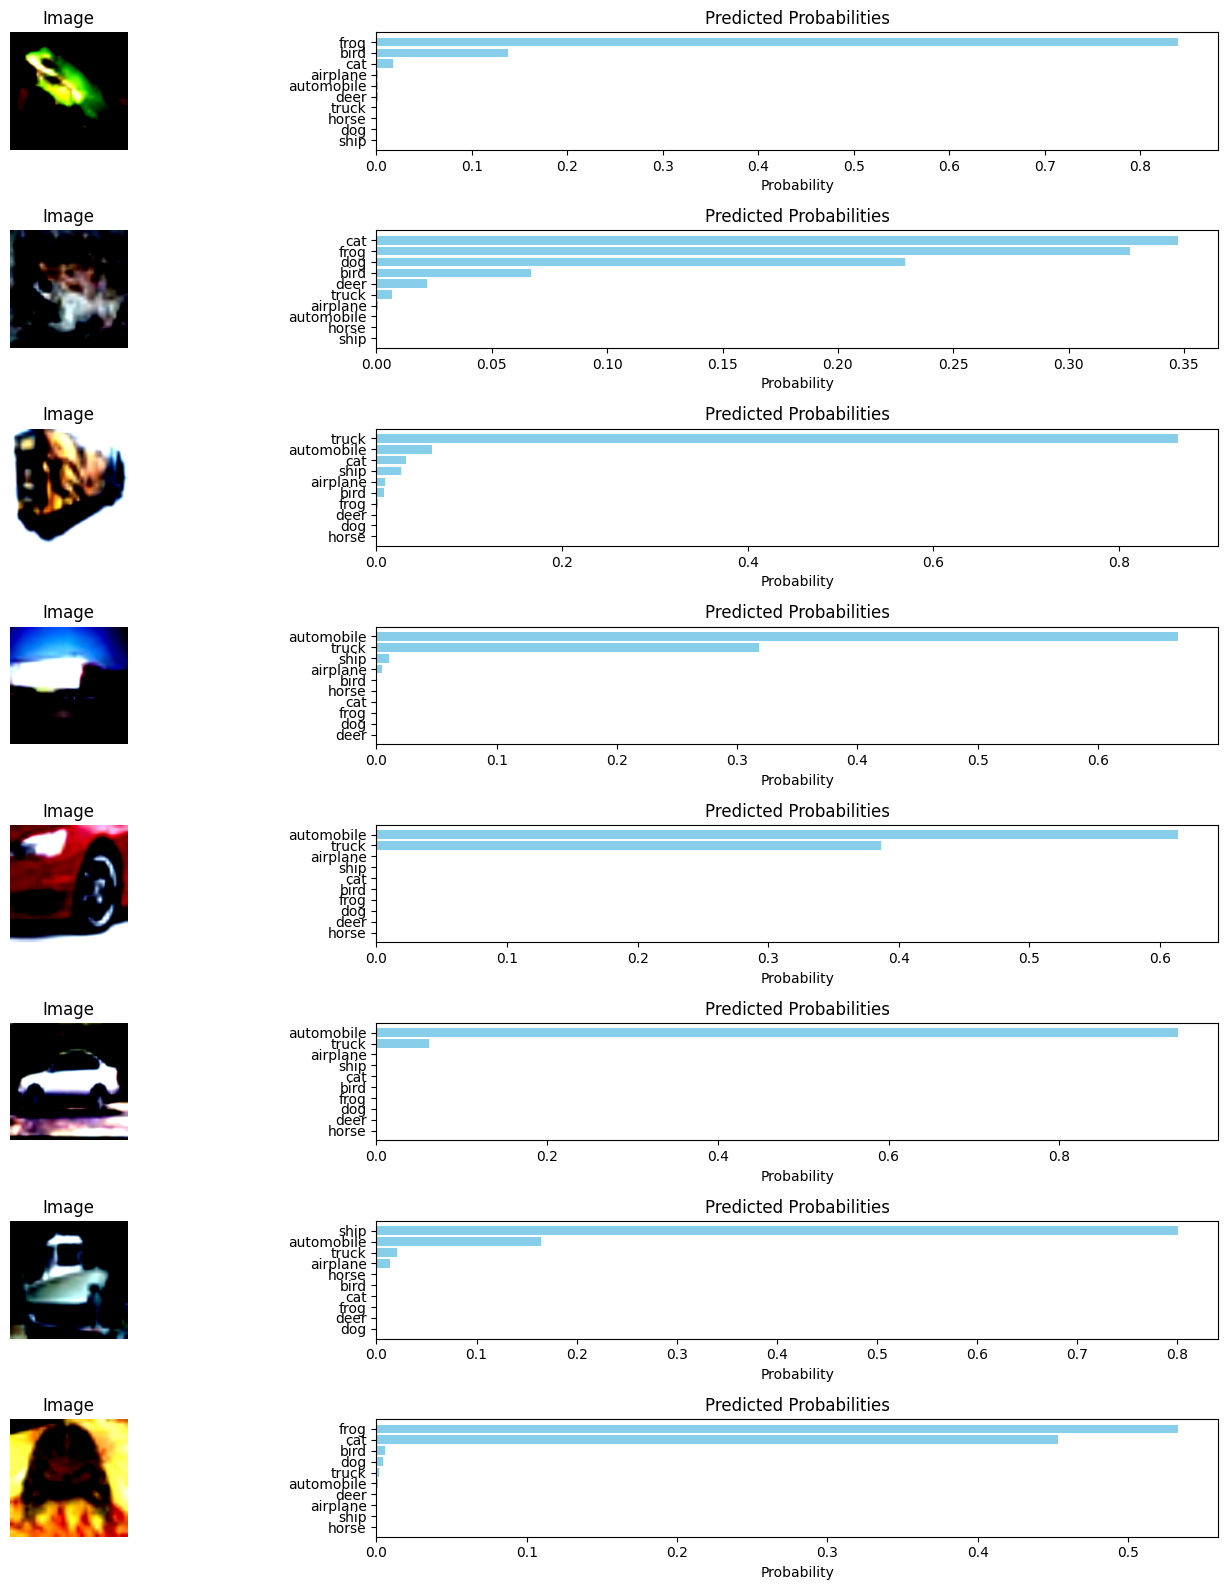

In [29]:
import matplotlib.pyplot as plt

# 첫 배치 가져오기
images, labels = next(iter(dataloader))
images = images.to(device)
with torch.no_grad():
    image_embedding = model.image_encoder(images)  # shape: (batch_size, proj_dim)
    logits = image_embedding @ text_embedding.T * torch.exp(model.temperature)
    probs = logits.softmax(dim=-1)

# 이미지 NumPy로 변환 (permute로 채널 순서를 맞추기)
images_np = images.cpu().permute(0, 2, 3, 1).numpy()  # shape: (batch_size, H, W, C)

# 시각화
num_images_to_plot = min(8, images_np.shape[0])
plt.figure(figsize=(16, 16))
for i in range(num_images_to_plot):
    # 원본 이미지 출력
    plt.subplot(num_images_to_plot, 2, 2 * i + 1)
    plt.imshow(images_np[i])
    plt.axis("off")
    plt.title("Image")

    # 예측 결과 출력: 전체 10개 클래스에 대한 확률을 내림차순으로 정렬해서 바 차트로 표시
    plt.subplot(num_images_to_plot, 2, 2 * i + 2)
    # 확률 배열 및 내림차순 정렬
    prob_i = probs[i].cpu().numpy()
    sorted_indices = np.argsort(-prob_i)
    sorted_probs = prob_i[sorted_indices]
    # text리스트 사용
    sorted_texts = [texts[idx] for idx in sorted_indices]
    plt.barh(range(len(texts)), sorted_probs, color="skyblue")
    plt.gca().invert_yaxis()
    plt.yticks(range(len(texts)), sorted_texts)
    plt.xlabel("Probability")
    plt.title("Predicted Probabilities")

plt.tight_layout()
plt.show()